## Import Libraries

In [39]:
import pandas as pd
import numpy as np

from pycaret.classification import *
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import seaborn as sns

from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task

import torch

import h2o
from h2o.automl import H2OAutoML

<a href="https://pub.towardsai.net/what-are-baseline-models-and-benchmarking-for-machine-learning-why-we-need-them-affe0714cd07"> Link </a>

This notebook focuses on the methodology to use baseline models as a starting point & reference in machine learning for further model development.<br>
In general, this reference point is important in the data science process to explain how the developed models perform (good or bad) and the baseline model's score serves as threshold for this evaluation.<br>

There are 3 types of baseline models:
1) Random Baseline Models 
2) ML Baseline Models 
3) Automated ML Baseline Models

---

## 1. Random Baseline Models

If data is not predictable, the best baseline model is a dummy classifier or dummy regressor.<br>
This way, in comparison to the baseline model, it's possible to evaluate the performance of the developed model.

In [4]:
np.random.seed(0)

random_dim = (1000, 3)
random_X = np.random.random(random_dim)
random_reg_y = np.random.randint(random_dim[1], size = random_dim[0])

In [5]:
train_clf = np.concatenate([random_X, random_reg_y.reshape(random_dim[0], 1)], axis = 1)
col_list = [str(i+1) for i in range(random_dim[1])]
col_list.append("target")

train_clf = pd.DataFrame(train_clf, columns = col_list)

train_clf["target"] = train_clf["target"].astype("str")

In [6]:
train_clf.sample(5)

,1,2,3,target
831,0.377430,0.670239,0.471664,2.0
394,0.664666,0.423054,0.198991,0.0
954,0.309050,0.069587,0.365474,0.0
696,0.705307,0.365676,0.395411,1.0
489,0.196451,0.671528,0.842973,2.0


In [7]:
clf = setup(
    data = train_clf,
    target = "target",
    numeric_features = col_list[:-1],
    verbose = 1,
    fold = 5
)

compare_models(
    sort = "Accuracy"
)

,Description,Value
0,Session id,8162
1,Target,target
2,Target type,Multiclass
3,Target mapping,"0.0: 0, 1.0: 1, 2.0: 2"
4,Original data shape,"(1000, 4)"
5,Transformed data shape,"(1000, 4)"
6,Transformed train set shape,"(700, 4)"
7,Transformed test set shape,"(300, 4)"
8,Numeric features,3
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.3557,0.0000,0.3557,0.3519,0.3487,0.0328,0.0329,0.8780
lda,Linear Discriminant Analysis,0.3543,0.0000,0.3543,0.3505,0.3473,0.0307,0.0308,0.0080
ridge,Ridge Classifier,0.3514,0.0000,0.3514,0.3441,0.3421,0.0263,0.0262,0.0120
svm,SVM - Linear Kernel,0.3429,0.0000,0.3429,0.2041,0.2150,0.0122,0.0127,0.0160
qda,Quadratic Discriminant Analysis,0.3414,0.0000,0.3414,0.3366,0.3354,0.0110,0.0112,0.0080
dummy,Dummy Classifier,0.3386,0.5000,0.3386,0.1146,0.1713,0.0000,0.0000,0.0100
ada,Ada Boost Classifier,0.3300,0.0000,0.3300,0.3317,0.3292,-0.0055,-0.0056,0.0240
dt,Decision Tree Classifier,0.3271,0.4952,0.3271,0.3261,0.3247,-0.0098,-0.0098,0.4140
lightgbm,Light Gradient Boosting Machine,0.3271,0.5009,0.3271,0.3276,0.3251,-0.0096,-0.0097,0.1820
nb,Naive Bayes,0.3257,0.5085,0.3257,0.3254,0.3206,-0.0121,-0.0124,0.4760


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=8162, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

The compare models function shows that the above shown model seems to perform best.

## 2. Machine Learning Baseline Models

if the data seems to be predictable, the next step is to create a ml baseline model.
<br>--> This model shows which feature is important for prediction. 

### Baseline Scores

Here the titanic dataset is the dataset for explaination:

In [8]:
titanic_train = pd.read_csv("./data/titanic_train.csv")

In [9]:
CAT_FEATURES = ["Sex", "Embarked"] 
NUM_FEATURES = ["Pclass", "Age", "SibSp", "Parch", "Fare"]
IGN_FEATURES = ["PassengerId", "Name", "Ticket", "Cabin"]

In [10]:
clf = setup(
    data = titanic_train,
    target = "Survived",
    normalize=True,
    normalize_method="robust",
    transformation = True,
    transformation_method="quantile",
    categorical_features = CAT_FEATURES,
    numeric_features = NUM_FEATURES,
    ignore_features = IGN_FEATURES
)

,Description,Value
0,Session id,793
1,Target,Survived
2,Target type,Binary
3,Original data shape,"(891, 12)"
4,Transformed data shape,"(891, 10)"
5,Transformed train set shape,"(623, 10)"
6,Transformed test set shape,"(268, 10)"
7,Ignore features,4
8,Numeric features,5
9,Categorical features,2


In [11]:
compare_models(sort='Accuracy')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8219,0.8807,0.7239,0.7978,0.7574,0.6173,0.6207,0.1200
gbc,Gradient Boosting Classifier,0.8123,0.8710,0.6984,0.7911,0.7391,0.5937,0.5987,0.0280
rf,Random Forest Classifier,0.8075,0.8687,0.7444,0.7561,0.7478,0.5923,0.5948,0.0610
ada,Ada Boost Classifier,0.7994,0.8475,0.7237,0.7456,0.7323,0.5724,0.5746,0.0290
knn,K Neighbors Classifier,0.7963,0.8491,0.6908,0.7567,0.7193,0.5608,0.5645,0.0460
lr,Logistic Regression,0.7881,0.8467,0.6980,0.7370,0.7139,0.5462,0.5494,0.0430
ridge,Ridge Classifier,0.7866,0.8499,0.7024,0.7296,0.7143,0.5441,0.5458,0.0150
et,Extra Trees Classifier,0.7865,0.8441,0.7150,0.7277,0.7186,0.5469,0.5498,0.0380
lda,Linear Discriminant Analysis,0.7850,0.8497,0.7024,0.7269,0.7128,0.5412,0.5430,0.0120
dt,Decision Tree Classifier,0.7801,0.7688,0.7076,0.7242,0.7108,0.5344,0.5395,0.0170


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=793, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [12]:
baseline_model = create_model("rf")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7937,0.8771,0.7917,0.7037,0.7451,0.5728,0.5756
1,0.7937,0.8483,0.7083,0.7391,0.7234,0.5590,0.5593
2,0.7937,0.8574,0.7083,0.7391,0.7234,0.5590,0.5593
3,0.7419,0.8138,0.6522,0.6522,0.6522,0.4470,0.4470
4,0.8387,0.8843,0.8333,0.7692,0.8000,0.6652,0.6667
5,0.7742,0.8750,0.7500,0.6923,0.7200,0.5313,0.5325
6,0.8710,0.9287,0.8333,0.8333,0.8333,0.7281,0.7281
7,0.8710,0.9211,0.7083,0.9444,0.8095,0.7149,0.7319
8,0.7742,0.7747,0.6667,0.7273,0.6957,0.5167,0.5179


In [13]:
baseline_preds = predict_model(baseline_model, raw_score=True)
baseline_preds

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8433,0.8427,0.7476,0.8280,0.7857,0.6627,0.6648


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived,prediction_label,prediction_score_0,prediction_score_1
111,3,female,14.5,1,0,14.4542,C,0,1,0.190,0.810
80,3,male,22.0,0,0,9.0000,S,0,0,0.990,0.010
22,3,female,15.0,0,0,8.0292,Q,1,1,0.440,0.560
824,3,male,2.0,4,1,39.6875,S,0,0,0.830,0.170
868,3,male,NaN,0,0,9.5000,S,0,0,0.650,0.350
...,...,...,...,...,...,...,...,...,...,...,...
349,3,male,42.0,0,0,8.6625,S,0,0,0.980,0.020
514,3,male,24.0,0,0,7.4958,S,0,0,1.000,0.000
427,2,female,19.0,0,0,26.0000,S,1,1,0.000,1.000
30,1,male,40.0,0,0,27.7208,C,0,0,0.755,0.245


In [14]:
baseline_scores = pull()
baseline_scores

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8433,0.8427,0.7476,0.828,0.7857,0.6627,0.6648


### Feature Engineering

In [15]:
titanic_train_feaEng = titanic_train.copy()
name_last = titanic_train_feaEng["Name"].str.split(" ", n = 1, expand=True)[1]
title = name_last.str.split(" ", n= 1, expand=True)[0]
titanic_train_feaEng["title"] = title

In [16]:
name_len = titanic_train_feaEng["Name"].str.len()
titanic_train_feaEng["Name_len"] = name_len

In [17]:
tfidf_vec = TfidfVectorizer(max_features=15, token_pattern="\w+")
svd = TruncatedSVD(n_components=10)
tfidf_array = svd.fit_transform(tfidf_vec.fit_transform(titanic_train_feaEng["Name"]))
for i in range(tfidf_array.shape[1]):
    titanic_train_feaEng['Name_' + str(i)] = tfidf_array [:,i]

In [18]:
cabin_first = []
cabin_last = []
cabin_len = []

for cabin in titanic_train_feaEng['Cabin']:
    try:
        re_list = re.split('(\d+)',cabin)
        if len(re_list) > 1:
            cabin_first.append(re_list[0])
            cabin_last.append(int(re_list[-2]))
            cabin_len.append(len(re_list))
        else:
            cabin_first.append('None')
            cabin_last.append(0)
            cabin_len.append(0)
    except:
        cabin_first.append('None')
        cabin_last.append(0)
        cabin_len.append(0)

titanic_train_feaEng['Cabin_First'] = cabin_first
titanic_train_feaEng['Cabin_Last'] = cabin_last
titanic_train_feaEng['Cabin_Len'] = cabin_len

In [19]:
# Ticket
tfidf_vec = TfidfVectorizer(max_features=5, analyzer="char")
svd = TruncatedSVD(n_components=3)
tfidf_array = svd.fit_transform(tfidf_vec.fit_transform(titanic_train_feaEng["Ticket"]))
for i in range(tfidf_array.shape[1]):
    titanic_train_feaEng['Ticket_' + str(i)] = tfidf_array [:,i]

new_features = ['title', 'Name_len','Name_0', 'Name_1', 'Name_2', 'Name_3', 'Name_4', 
                'Name_5', 'Name_6', 'Name_7', 'Name_8', 'Name_9', 'Cabin_First', 
                'Cabin_Last', 'Cabin_Len', 'Ticket_0', 'Ticket_1', 'Ticket_2']
old_features = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp',
                'Parch', 'Fare', 'Embarked']

### Feature Importance

In [20]:
feature_score_dict = {}

for index, feature in enumerate(new_features):
    old_features_temp = old_features.copy()
    old_features_temp.append(feature)
    titanic_train_FeaEng_temp = titanic_train_feaEng[old_features_temp].copy()
    
    clf = setup(data=titanic_train_FeaEng_temp, 
            target='Survived',
            normalize = True, #normalisation helps some algorithms
            normalize_method = 'robust', #resilient to outliers
            transformation = True, #applies transformation to target column
            transformation_method = 'quantile',
            data_split_shuffle = True, #so that we do not use "future" observations to predict "past" observations
            session_id = 42,
            use_gpu = False,
            fold = 10,
            n_jobs = -1,
            verbose= False
            )
    
    baseline_model = create_model('rf')
    scores = pull()
    feature_score_dict[feature] = scores

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7619,0.8419,0.7500,0.6667,0.7059,0.5070,0.5095
1,0.7143,0.8387,0.5000,0.6667,0.5714,0.3636,0.3721
2,0.8254,0.8547,0.7083,0.8095,0.7556,0.6207,0.6240
3,0.8226,0.9125,0.8261,0.7308,0.7755,0.6298,0.6330
4,0.8548,0.8141,0.6667,0.9412,0.7805,0.6767,0.6992
5,0.8871,0.9117,0.8333,0.8696,0.8511,0.7602,0.7607
6,0.8226,0.9172,0.7083,0.8095,0.7556,0.6173,0.6207
7,0.7742,0.7834,0.6250,0.7500,0.6818,0.5090,0.5141
8,0.7903,0.8207,0.7083,0.7391,0.7234,0.5547,0.5550


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8254,0.8462,0.7500,0.7826,0.7660,0.6268,0.6272
1,0.7778,0.8910,0.5833,0.7778,0.6667,0.5051,0.5168
2,0.7778,0.8542,0.6250,0.7500,0.6818,0.5132,0.5183
3,0.8548,0.9298,0.8261,0.7917,0.8085,0.6917,0.6921
4,0.8710,0.8487,0.6667,1.0000,0.8000,0.7103,0.7421
5,0.9032,0.9084,0.8333,0.9091,0.8696,0.7929,0.7948
6,0.8065,0.8607,0.7083,0.7727,0.7391,0.5857,0.5871
7,0.8065,0.7758,0.6250,0.8333,0.7143,0.5724,0.5860
8,0.8226,0.8240,0.7083,0.8095,0.7556,0.6173,0.6207


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7778,0.8675,0.7500,0.6923,0.7200,0.5363,0.5375
1,0.7460,0.8584,0.5833,0.7000,0.6364,0.4437,0.4481
2,0.8254,0.8681,0.7500,0.7826,0.7660,0.6268,0.6272
3,0.8226,0.9236,0.8261,0.7308,0.7755,0.6298,0.6330
4,0.8548,0.8152,0.6667,0.9412,0.7805,0.6767,0.6992
5,0.8871,0.9101,0.8333,0.8696,0.8511,0.7602,0.7607
6,0.8387,0.8788,0.7083,0.8500,0.7727,0.6493,0.6558
7,0.8065,0.7610,0.6667,0.8000,0.7273,0.5792,0.5850
8,0.7742,0.8317,0.6667,0.7273,0.6957,0.5167,0.5179


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7937,0.8766,0.7917,0.7037,0.7451,0.5728,0.5756
1,0.8254,0.8536,0.6667,0.8421,0.7442,0.6144,0.6240
2,0.8095,0.8627,0.7083,0.7727,0.7391,0.5896,0.5910
3,0.8387,0.9287,0.8696,0.7407,0.8000,0.6663,0.6723
4,0.8710,0.8158,0.7083,0.9444,0.8095,0.7149,0.7319
5,0.8871,0.8958,0.7917,0.9048,0.8444,0.7565,0.7606
6,0.8387,0.8772,0.6667,0.8889,0.7619,0.6437,0.6589
7,0.7903,0.7522,0.6250,0.7895,0.6977,0.5405,0.5491
8,0.8065,0.8333,0.7083,0.7727,0.7391,0.5857,0.5871


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8254,0.8611,0.7917,0.7600,0.7755,0.6328,0.6331
1,0.7778,0.8488,0.6250,0.7500,0.6818,0.5132,0.5183
2,0.8413,0.8649,0.7917,0.7917,0.7917,0.6635,0.6635
3,0.8226,0.9275,0.8696,0.7143,0.7843,0.6361,0.6450
4,0.8226,0.8026,0.6250,0.8824,0.7317,0.6049,0.6249
5,0.8548,0.8854,0.7917,0.8261,0.8085,0.6917,0.6921
6,0.8387,0.8931,0.6667,0.8889,0.7619,0.6437,0.6589
7,0.7903,0.7478,0.6250,0.7895,0.6977,0.5405,0.5491
8,0.8226,0.8295,0.7500,0.7826,0.7660,0.6232,0.6236


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7937,0.8558,0.7917,0.7037,0.7451,0.5728,0.5756
1,0.7937,0.8472,0.6667,0.7619,0.7111,0.5517,0.5547
2,0.7937,0.8558,0.7500,0.7200,0.7347,0.5660,0.5663
3,0.8548,0.9331,0.9130,0.7500,0.8235,0.7022,0.7121
4,0.8548,0.8202,0.6667,0.9412,0.7805,0.6767,0.6992
5,0.8710,0.9035,0.7917,0.8636,0.8261,0.7238,0.7256
6,0.8387,0.8788,0.6667,0.8889,0.7619,0.6437,0.6589
7,0.7903,0.7560,0.6250,0.7895,0.6977,0.5405,0.5491
8,0.8065,0.8394,0.7500,0.7500,0.7500,0.5921,0.5921


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7937,0.8638,0.7917,0.7037,0.7451,0.5728,0.5756
1,0.7778,0.8494,0.6250,0.7500,0.6818,0.5132,0.5183
2,0.8095,0.8520,0.7500,0.7500,0.7500,0.5962,0.5962
3,0.8548,0.9220,0.9130,0.7500,0.8235,0.7022,0.7121
4,0.8548,0.8092,0.6667,0.9412,0.7805,0.6767,0.6992
5,0.8871,0.9002,0.7917,0.9048,0.8444,0.7565,0.7606
6,0.8548,0.8734,0.7083,0.8947,0.7907,0.6819,0.6928
7,0.8065,0.7719,0.6667,0.8000,0.7273,0.5792,0.5850
8,0.7742,0.8421,0.6667,0.7273,0.6957,0.5167,0.5179


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8095,0.8713,0.7917,0.7308,0.7600,0.6025,0.6039
1,0.7460,0.8280,0.6250,0.6818,0.6522,0.4528,0.4538
2,0.8413,0.8590,0.7500,0.8182,0.7826,0.6580,0.6595
3,0.8710,0.9326,0.9130,0.7778,0.8400,0.7330,0.7397
4,0.8387,0.8010,0.6667,0.8889,0.7619,0.6437,0.6589
5,0.8871,0.8909,0.7917,0.9048,0.8444,0.7565,0.7606
6,0.8548,0.8882,0.7083,0.8947,0.7907,0.6819,0.6928
7,0.7742,0.7566,0.6250,0.7500,0.6818,0.5090,0.5141
8,0.7903,0.8218,0.7083,0.7391,0.7234,0.5547,0.5550


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7937,0.8665,0.7500,0.7200,0.7347,0.5660,0.5663
1,0.7619,0.8483,0.6250,0.7143,0.6667,0.4828,0.4854
2,0.8730,0.8942,0.8333,0.8333,0.8333,0.7308,0.7308
3,0.8065,0.9331,0.8261,0.7037,0.7600,0.5996,0.6050
4,0.8387,0.8026,0.6667,0.8889,0.7619,0.6437,0.6589
5,0.9032,0.8986,0.8333,0.9091,0.8696,0.7929,0.7948
6,0.8387,0.8783,0.6667,0.8889,0.7619,0.6437,0.6589
7,0.7903,0.7516,0.6250,0.7895,0.6977,0.5405,0.5491
8,0.8226,0.8388,0.7500,0.7826,0.7660,0.6232,0.6236


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8095,0.8755,0.7917,0.7308,0.7600,0.6025,0.6039
1,0.7302,0.8387,0.5833,0.6667,0.6222,0.4138,0.4160
2,0.8254,0.8814,0.7500,0.7826,0.7660,0.6268,0.6272
3,0.8548,0.9314,0.8696,0.7692,0.8163,0.6971,0.7006
4,0.8548,0.8114,0.6667,0.9412,0.7805,0.6767,0.6992
5,0.8548,0.8914,0.7917,0.8261,0.8085,0.6917,0.6921
6,0.8065,0.8816,0.6667,0.8000,0.7273,0.5792,0.5850
7,0.7903,0.7604,0.6250,0.7895,0.6977,0.5405,0.5491
8,0.8065,0.8306,0.7500,0.7500,0.7500,0.5921,0.5921


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8095,0.8670,0.7917,0.7308,0.7600,0.6025,0.6039
1,0.7937,0.8355,0.6667,0.7619,0.7111,0.5517,0.5547
2,0.8413,0.8697,0.7500,0.8182,0.7826,0.6580,0.6595
3,0.8548,0.9398,0.9130,0.7500,0.8235,0.7022,0.7121
4,0.8548,0.7999,0.6667,0.9412,0.7805,0.6767,0.6992
5,0.8710,0.9002,0.7917,0.8636,0.8261,0.7238,0.7256
6,0.8387,0.8690,0.6667,0.8889,0.7619,0.6437,0.6589
7,0.7903,0.7484,0.6250,0.7895,0.6977,0.5405,0.5491
8,0.7903,0.8306,0.7083,0.7391,0.7234,0.5547,0.5550


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8095,0.8761,0.7917,0.7308,0.7600,0.6025,0.6039
1,0.7619,0.8440,0.6250,0.7143,0.6667,0.4828,0.4854
2,0.8254,0.8542,0.7500,0.7826,0.7660,0.6268,0.6272
3,0.8548,0.9275,0.9130,0.7500,0.8235,0.7022,0.7121
4,0.8548,0.8043,0.6667,0.9412,0.7805,0.6767,0.6992
5,0.8871,0.9106,0.8333,0.8696,0.8511,0.7602,0.7607
6,0.8226,0.8893,0.6250,0.8824,0.7317,0.6049,0.6249
7,0.7742,0.7697,0.6250,0.7500,0.6818,0.5090,0.5141
8,0.8065,0.8350,0.7500,0.7500,0.7500,0.5921,0.5921


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7937,0.8814,0.7917,0.7037,0.7451,0.5728,0.5756
1,0.7619,0.8590,0.6250,0.7143,0.6667,0.4828,0.4854
2,0.8254,0.8435,0.7083,0.8095,0.7556,0.6207,0.6240
3,0.8871,0.9142,0.8696,0.8333,0.8511,0.7602,0.7607
4,0.8387,0.8141,0.6667,0.8889,0.7619,0.6437,0.6589
5,0.9032,0.9068,0.8333,0.9091,0.8696,0.7929,0.7948
6,0.8065,0.8991,0.8333,0.7143,0.7692,0.6043,0.6096
7,0.7419,0.7533,0.6250,0.6818,0.6522,0.4477,0.4487
8,0.8710,0.8410,0.7917,0.8636,0.8261,0.7238,0.7256


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8254,0.8793,0.8333,0.7407,0.7843,0.6385,0.6416
1,0.7460,0.8627,0.5417,0.7222,0.6190,0.4343,0.4445
2,0.8254,0.8504,0.7500,0.7826,0.7660,0.6268,0.6272
3,0.8548,0.9058,0.8696,0.7692,0.8163,0.6971,0.7006
4,0.8548,0.8388,0.6667,0.9412,0.7805,0.6767,0.6992
5,0.9032,0.9090,0.8333,0.9091,0.8696,0.7929,0.7948
6,0.8387,0.8876,0.7917,0.7917,0.7917,0.6601,0.6601
7,0.7742,0.7785,0.6250,0.7500,0.6818,0.5090,0.5141
8,0.8548,0.8635,0.7500,0.8571,0.8000,0.6869,0.6906


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8095,0.8814,0.7917,0.7308,0.7600,0.6025,0.6039
1,0.7302,0.8558,0.5417,0.6842,0.6047,0.4040,0.4104
2,0.8095,0.8365,0.7500,0.7500,0.7500,0.5962,0.5962
3,0.8387,0.9075,0.8696,0.7407,0.8000,0.6663,0.6723
4,0.8548,0.8273,0.6667,0.9412,0.7805,0.6767,0.6992
5,0.9032,0.8953,0.8333,0.9091,0.8696,0.7929,0.7948
6,0.8387,0.8953,0.8333,0.7692,0.8000,0.6652,0.6667
7,0.7742,0.7544,0.6250,0.7500,0.6818,0.5090,0.5141
8,0.8548,0.8531,0.8333,0.8000,0.8163,0.6964,0.6968


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8571,0.8579,0.7917,0.8261,0.8085,0.6947,0.6951
1,0.7619,0.8723,0.5833,0.7368,0.6512,0.4741,0.4816
2,0.8730,0.8771,0.7500,0.9000,0.8182,0.7219,0.7289
3,0.8710,0.9376,0.9130,0.7778,0.8400,0.7330,0.7397
4,0.8387,0.8125,0.6250,0.9375,0.7500,0.6379,0.6664
5,0.9194,0.9194,0.8333,0.9524,0.8889,0.8260,0.8306
6,0.8387,0.8794,0.7083,0.8500,0.7727,0.6493,0.6558
7,0.8065,0.8388,0.5833,0.8750,0.7000,0.5654,0.5908
8,0.8710,0.8547,0.7917,0.8636,0.8261,0.7238,0.7256


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8254,0.8424,0.7500,0.7826,0.7660,0.6268,0.6272
1,0.7937,0.8739,0.6250,0.7895,0.6977,0.5442,0.5528
2,0.8571,0.8446,0.7500,0.8571,0.8000,0.6897,0.6934
3,0.8387,0.9415,0.8696,0.7407,0.8000,0.6663,0.6723
4,0.8548,0.8399,0.6667,0.9412,0.7805,0.6767,0.6992
5,0.9194,0.9200,0.8333,0.9524,0.8889,0.8260,0.8306
6,0.8387,0.8849,0.7500,0.8182,0.7826,0.6548,0.6564
7,0.8226,0.8427,0.6667,0.8421,0.7442,0.6112,0.6209
8,0.8548,0.8624,0.7500,0.8571,0.8000,0.6869,0.6906


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8571,0.8643,0.8333,0.8000,0.8163,0.6995,0.6999
1,0.8254,0.8964,0.6250,0.8824,0.7317,0.6078,0.6277
2,0.8413,0.8568,0.7500,0.8182,0.7826,0.6580,0.6595
3,0.9032,0.9454,0.9565,0.8148,0.8800,0.7998,0.8070
4,0.8226,0.8487,0.5833,0.9333,0.7179,0.5984,0.6335
5,0.9032,0.9139,0.8333,0.9091,0.8696,0.7929,0.7948
6,0.8387,0.8865,0.7917,0.7917,0.7917,0.6601,0.6601
7,0.7903,0.8487,0.6250,0.7895,0.6977,0.5405,0.5491
8,0.8710,0.8799,0.7917,0.8636,0.8261,0.7238,0.7256


In [23]:
metric_list = []
feature_list = []
score_list = []

for key in feature_score_dict.keys():
    metric_list.extend(list(feature_score_dict[key].columns))
    score_list.extend(list(feature_score_dict[key].loc['Mean', :]))
    feature_list.extend([key for i in range(len(feature_score_dict[key].columns))])

all_scores_pd = pd.DataFrame()
all_scores_pd['Metric'] = metric_list
all_scores_pd['Feature'] = feature_list
all_scores_pd['Score'] = score_list

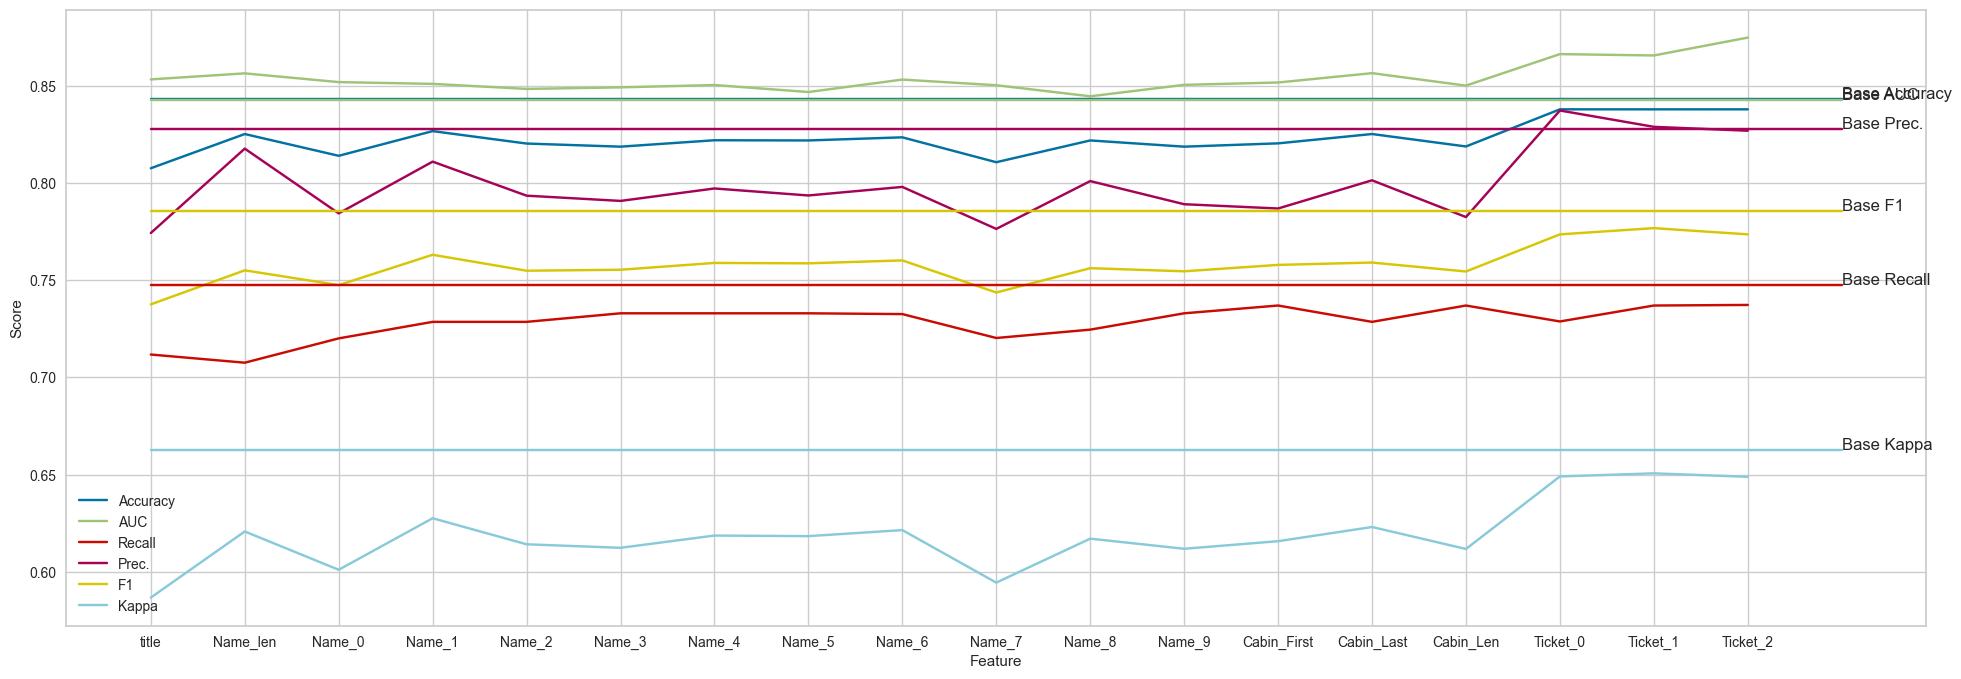

In [24]:
col_list = ['Accuracy', 'AUC', 'Recall', 'Prec.', 'F1', 'Kappa']
score_color = {'Accuracy':'C0', 'AUC':'C1', 'Recall':'C2', 'Prec.':'C3', 'F1':'C4', 'Kappa':'C5'}
fig, ax = plt.subplots(figsize=(24, 8))
all_scores_pd = all_scores_pd.loc[all_scores_pd['Metric'] != 'MCC', :]
sns.lineplot(data=all_scores_pd, x='Feature', y='Score', hue='Metric', ax=ax, palette=score_color)
ax.legend(loc="lower left")
for base_col in col_list:
    base_score = baseline_scores.loc[:, base_col].values[0]
    ax.plot([0, len(all_scores_pd['Feature'].unique())], [base_score, base_score], color=score_color[base_col])
    ax.text(len(all_scores_pd['Feature'].unique()), base_score, 'Base ' + base_col);

## 3. Automated Machine Learning Baseline Models

the final baseline model is the automated ml baseline model.<br>
It's a very good model for benchmarking the developed ml model. <br>

If the automated baseline model can be beaten, the achieved model can strongly recommanded to become a product

### LightAutoML

In [28]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 300

In [29]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [33]:
#functions
def acc_score(y_true, y_pred, **kwargs):
    return accuracy_score(y_true, (y_pred > 0.5).astype(int), **kwargs)

def f1_metric(y_true, y_pred, **kwargs):
    return f1_score(y_true, (y_pred>0.5).astype(int), **kwargs)

task = Task("binary", metric = acc_score)

roles = {
    "target": "Survived",
    "drop": ["Passengerid", "Name", "Ticket"]
}

In [36]:
%%time
n_fold = 3
skf = StratifiedKFold(n_splits = n_fold)
skf.get_n_splits(titanic_train)

acc_list = []
for train_index, test_index in skf.split(titanic_train, titanic_train["Survived"]):
    
    X_train, X_test = titanic_train.loc[train_index, :], titanic_train.loc[test_index, :]
    y = X_test["Survived"]
    X_test.drop(["Survived"], axis = 1, inplace = True)

    automl = TabularUtilizedAutoML(
        task = task,
        cpu_limit = N_THREADS,
        general_params = {
            "use_algos": [["linear_l2", "lgb", "lgb_tuned"]]
        },
        reader_params = {"n_jobs": N_THREADS}
    )

    automl.fit_predict(X_train, roles = roles)

    test_pred = automl.predict(X_test)
    test_pred = (test_pred.data[:, 0]>0.5).astype(int)
    acc_list.append(acc_score(y, test_pred))

lightautoml_acc_score = sum(acc_list) / n_fold
print("lightautoml_acc_score: ", lightautoml_acc_score)


lightautoml_acc_score:  0.8092031425364757
CPU times: total: 5h 37min 58s
Wall time: 1h 18min 26s


### H2o AutoML

In [40]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) Client VM (build 25.152-b16, mixed mode, sharing)
  Starting server from C:\Users\z635177\OneDrive - ZF Friedrichshafen AG\Desktop\Statistics\.venv\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\z635177\AppData\Local\Temp\tmpsj61g3_8
  JVM stdout: C:\Users\z635177\AppData\Local\Temp\tmpsj61g3_8\h2o_Z635177_started_from_python.out
  JVM stderr: C:\Users\z635177\AppData\Local\Temp\tmpsj61g3_8\h2o_Z635177_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,3 months and 2 days
H2O_cluster_name:,H2O_from_python_Z635177_jkazpv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,247.5 Mb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"locked, healthy"
